In [1]:
# multivariate multi-step data preparation
from numpy import array
from numpy import hstack
import pandas as pd
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR


c:\users\manel\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
c:\users\manel\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
dades = read_csv('dadesSauMulti.csv', sep=';',header=0, index_col=0)

vol = dades['Volum']
tm = dades['TM']
hrm = dades['HRM']
ppt = dades['PPT']
pm = dades['PM']

# convert to [rows, columns] structure
vol = vol.reshape((len(vol), 1))
tm = tm.reshape((len(tm), 1))
hrm = hrm.reshape((len(hrm), 1))
ppt = ppt.reshape((len(ppt), 1))
pm = pm.reshape((len(pm), 1))


# horizontally stack columns
dataset = hstack((vol,tm,hrm,ppt,pm,vol))

scaler = MinMaxScaler(feature_range=(0, 1))
datasetN = scaler.fit_transform(dataset)

c:\users\manel\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  # Remove the CWD from sys.path while we load stuff.
c:\users\manel\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  # This is added back by InteractiveShellApp.init_path()
c:\users\manel\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if sys.path[0] == '':
c:\users\manel\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  de

In [3]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


In [4]:
def train_test (n_steps_in, n_steps_out, propTrainTest, dataset):
    
    n_steps_in, n_steps_out = n_steps_in, n_steps_out
    # split train test
    X, y = split_sequences(dataset, n_steps_in, n_steps_out)
    
    train_size = int(len(X) * propTrainTest)
    test_size = len(dataset) - train_size
    train_X, test_X = X[0:train_size,:], X[train_size:len(X),:]
    train_Y, test_Y = y[0:train_size,:], y[train_size:len(y),:]
    
    return (train_X, test_X, train_Y, test_Y)

In [5]:
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculem RMSE per cada dia
    for i in range(actual.shape[1]):
        # calculem MSE
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculem RMSE
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
    # calcul global de RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

In [6]:
n_steps_in = 30
n_steps_out = 15
propTrainTest = 0.8
train_X, test_X, train_Y, test_Y = train_test(n_steps_in, n_steps_out, propTrainTest, datasetN)

In [7]:
# flatten input
n_input = train_X.shape[1] * train_X.shape[2]
train_X = train_X.reshape((train_X.shape[0], n_input))
test_X = test_X.reshape((test_X.shape[0], n_input))

In [8]:
from scipy.stats import uniform
from scipy.stats import randint
dense=[]
epochs=[]
lr=[]
batch=[]
num_repeticions=250

for i in range(num_repeticions):
    dense.append(randint.rvs(5, 500))
    epochs.append(randint.rvs(50, 1200))
    lr.append(uniform.rvs(0.0001, 0.01))
    batch.append(randint.rvs(8, 128))



In [9]:
from keras import optimizers
#Simulació RandomizedSearchCV per SVM
resultat=[]

for den, epoch, l_r, bat in zip(dense, epochs, lr, batch):
    adam = optimizers.Adam(lr=l_r)
    model = Sequential()
    model.add(Dense(den, activation='sigmoid', input_dim=n_input))
    model.add(Dense(n_steps_out))
    model.compile(loss='mse', optimizer=adam)
    # fit model
    modelfit = model.fit(train_X, train_Y, epochs=epoch, batch_size=bat, verbose=0)
    # Predict on new data
    yhat = model.predict(test_X)        # invertim prediccions per tenir-les en l'escala original
    # invertim prediccions per tenir-les en l'escala original
    yhat2 = yhat.reshape((yhat.shape[0]*yhat.shape[1], 1))
    test_Y2 = test_Y.reshape((test_Y.shape[0]*test_Y.shape[1], 1))
    #dataset2 = hstack((yhat2,yhat2,yhat2,yhat2,yhat2,yhat2,yhat2,test_Y2))
    dataset2 = hstack((yhat2,yhat2,yhat2,yhat2,yhat2,test_Y2))
    inv_yhat = scaler.inverse_transform(dataset2)
    testPredict = inv_yhat[:,0].reshape(test_Y.shape[0], test_Y.shape[1])
    #test_YR = inv_yhat[:,7].reshape(test_Y.shape[0], test_Y.shape[1])
    test_YR = inv_yhat[:,5].reshape(test_Y.shape[0], test_Y.shape[1])

    RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
    print(RMSE_TOT,den, epoch, l_r, bat)
    resultat.append((den, epoch, l_r, bat, RMSE_days,RMSE_TOT))
                 
    

8.63846878525841 98 1135 0.008028259331657532 71
9.60215571238683 433 1185 0.002696558319710671 80
8.005602303692553 125 483 0.004480120558938979 77
6.222692287671618 35 488 0.0006915562676558595 65
9.486522991879003 398 1198 0.009593621187131054 79
6.704563513986571 324 86 0.006828546362949572 8
7.435071230423315 421 567 0.006584124720669492 12
6.886586510549784 184 232 0.008305672823312812 62
8.41696161819136 363 895 0.00547574122361438 127
8.28359628480557 208 797 0.002839193856266724 47
7.449932687045351 96 390 0.001038757070719375 16
6.782523407264736 243 482 0.005186304373045434 125
8.008554567335054 270 56 0.008837244863266858 106
6.9696245757974165 373 306 0.001969057846415476 55
9.743066119502393 463 1062 0.008524102398081303 118
8.16056769280625 109 494 0.0019346282434772077 14
7.370704213920253 61 881 0.0020254660246976086 121
8.809579002488128 144 1198 0.00808879020586371 15
8.222178750677699 255 902 0.003886389391090208 8
7.2976634946287575 398 163 0.008044650555552497 36


6.394676969276519 9 979 0.004269308107468535 127
8.438340954440834 258 890 0.00427499678046119 60
7.217058088262921 237 1008 0.0007280030711735152 58
8.25428243721132 390 591 0.004552054252264461 16
7.908833332085894 169 652 0.005308625233836685 108
7.298000956286707 172 918 0.002976676550313787 114
8.80606909641397 189 1008 0.004000003847162802 15
8.774604965686919 279 1180 0.0053296294446204375 62
7.4472772094704505 304 222 0.008730436885822312 118
7.560008259363577 69 1082 0.0030376666349837787 40
6.342629703877674 234 59 0.00902518812883126 44
7.2750688738706435 208 859 0.008057890963182622 32
8.462496519750998 275 922 0.006814266587810511 67
7.979845886530299 108 596 0.004926059609474285 84
8.069493003724135 360 1056 0.00611603335656614 18
8.330023251969454 20 644 0.009100454164928608 74
8.356050687015134 149 809 0.00843147782068311 71
8.774574806022292 385 1161 0.008328914037897341 58
7.62513610198125 262 1175 0.008117657974977441 25
6.237959867695471 75 213 0.004186406322443665 

In [10]:
varlist = []
for i in range(len(dense)):
    varlist.append(resultat[i])
    
resultFinal = pd.DataFrame(varlist)
resultFinal.columns=['nº neurones','epochs',  'learning rate','batch size', 'RMSE_dayws', 'RMSE_total' ]
resultFinal = resultFinal.sort_values(by='RMSE_total', ascending=True)
resultFinal = resultFinal.reset_index(drop=True)

resultFinal[0:15]

,nº neurones,epochs,learning rate,batch size,RMSE_dayws,RMSE_total
0,48,337,0.000790,126,"[2.130329578476362, 2.6204986579427745, 3.3308...",5.705154
1,266,629,0.000117,38,"[1.5728519523399844, 2.228354268782133, 2.9049...",5.728432
2,497,520,0.000236,69,"[3.406117530688648, 2.243230353299105, 2.98928...",5.743822
3,254,489,0.000164,122,"[2.0902606699210566, 2.6627076214306777, 3.279...",5.753856
4,168,304,0.000271,31,"[1.7619499431365018, 2.4630744119937833, 3.058...",5.787135
5,103,598,0.000219,47,"[1.87222427951025, 2.5549141478764597, 3.25369...",5.821682
6,380,497,0.000227,40,"[1.6315510911741113, 2.450009068908885, 2.9867...",5.822624
7,84,108,0.002421,115,"[2.4198842277995016, 3.453993970910813, 3.2259...",5.840982
8,38,371,0.000625,67,"[2.0003791000967697, 2.4951682543969866, 3.099...",5.843845
9,200,468,0.001038,104,"[2.0549076967071223, 2.5190241992653126, 3.024...",5.845066


In [13]:
adam = optimizers.Adam(lr=0.000790)
model = Sequential()
model.add(Dense(48, activation='sigmoid', input_dim=n_input))
model.add(Dense(n_steps_out))
model.compile(loss='mse', optimizer=adam)
# fit model
modelfit = model.fit(train_X, train_Y, epochs=337, batch_size=126, verbose=0)
# Predict on new data
yhat = model.predict(test_X)        # invertim prediccions per tenir-les en l'escala original
# invertim prediccions per tenir-les en l'escala original
yhat2 = yhat.reshape((yhat.shape[0]*yhat.shape[1], 1))
test_Y2 = test_Y.reshape((test_Y.shape[0]*test_Y.shape[1], 1))
#dataset2 = hstack((yhat2,yhat2,yhat2,yhat2,yhat2,yhat2,yhat2,test_Y2))
dataset2 = hstack((yhat2,yhat2,yhat2,yhat2,yhat2,test_Y2))
inv_yhat = scaler.inverse_transform(dataset2)
testPredict = inv_yhat[:,0].reshape(test_Y.shape[0], test_Y.shape[1])
#test_YR = inv_yhat[:,7].reshape(test_Y.shape[0], test_Y.shape[1])
test_YR = inv_yhat[:,5].reshape(test_Y.shape[0], test_Y.shape[1])

RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)

In [14]:
print(RMSE_TOT)

5.759029777287924


In [15]:
import matplotlib.pyplot as plt
dies = list()
    # calculem RMSE per cada dia
    
for i in range(test_YR.shape[1]):
    # calculem MSE
    dies.append((test_YR[:, i], testPredict[:, i]))

%matplotlib inline
plt.rcParams["figure.figsize"] = [15,10]
title1 = '1 dia - Sau - RMSE: '+str(round(RMSE_days[0],3))
title5 = '5 dies - Sau - RMSE: '+str(round(RMSE_days[4],3))
title10 = '10 dies - Sau - RMSE: '+str(round(RMSE_days[9],3))
title15 = '15 dies - Sau - RMSE: '+str(round(RMSE_days[14],3))

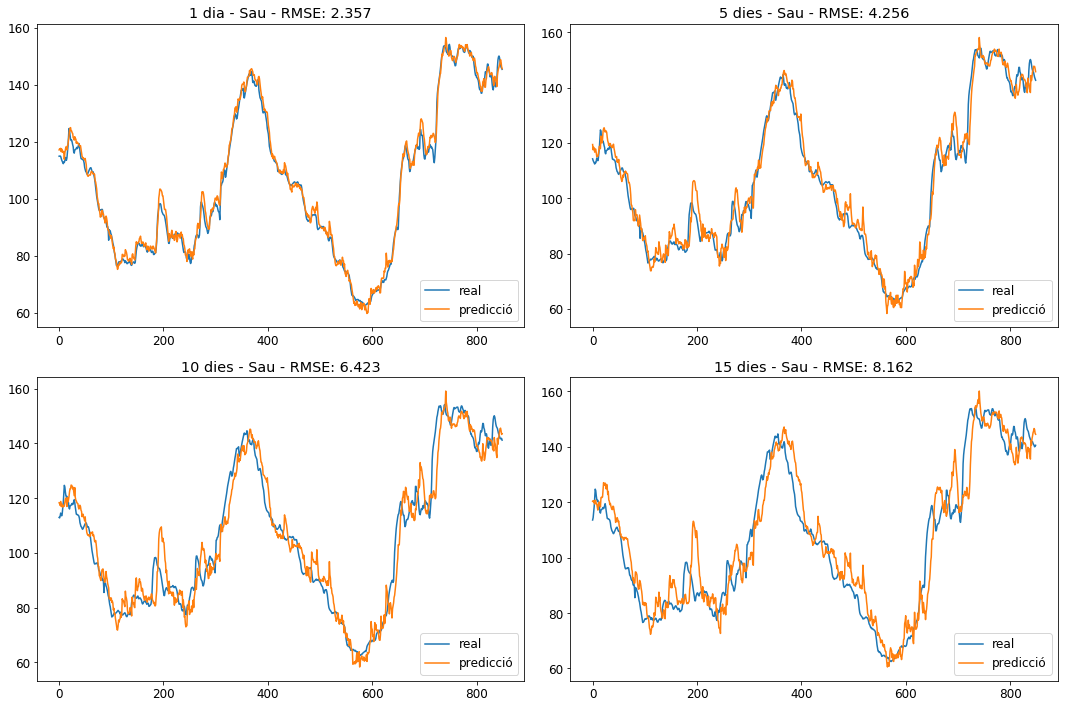

In [18]:
plt.rcParams.update({'font.size': 12})

plt.subplots_adjust(hspace=0.5)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# plot time signal:
axes[0, 0].set_title(title1)
axes[0, 0].plot(dies[0][0], label='real')
axes[0, 0].plot(dies[0][1], label='predicció')
axes[0, 0].legend(loc=4)

axes[0, 1].set_title(title5)
axes[0, 1].plot(dies[4][0], label='real')
axes[0, 1].plot(dies[4][1], label='predicció')
axes[0, 1].legend(loc=4)

axes[1, 0].set_title(title10)
axes[1, 0].plot(dies[9][0], label='real')
axes[1, 0].plot(dies[9][1], label='predicció')
axes[1, 0].legend(loc=4)

axes[1, 1].set_title(title15)
axes[1, 1].plot(dies[14][0], label='real')
axes[1, 1].plot(dies[14][1], label='predicció')
axes[1, 1].legend(loc=4)


fig.tight_layout()
plt.show()

In [17]:
from tabulate import tabulate
headers=[]
for i in range(len(RMSE_days)):
    headers.append('dia '+str(i+1))

headers.append('Total')
v = RMSE_days
ultim = v.append(RMSE_TOT)
table1 = tabulate([RMSE_days[0:5]], headers[0:5], tablefmt="fancy_grid")
table2 = tabulate([RMSE_days[5:10]], headers[5:10], tablefmt="fancy_grid")
table3 = tabulate([RMSE_days[10:16]], headers[10:16], tablefmt="fancy_grid")
#output
print(table1)
print(table2)
print(table3)

╒═════════╤═════════╤═════════╤═════════╤═════════╕
│   dia 1 │   dia 2 │   dia 3 │   dia 4 │   dia 5 │
╞═════════╪═════════╪═════════╪═════════╪═════════╡
│  2.3569 │ 2.80746 │ 3.60264 │ 3.99309 │ 4.25607 │
╘═════════╧═════════╧═════════╧═════════╧═════════╛
╒═════════╤═════════╤═════════╤═════════╤══════════╕
│   dia 6 │   dia 7 │   dia 8 │   dia 9 │   dia 10 │
╞═════════╪═════════╪═════════╪═════════╪══════════╡
│ 4.74306 │  5.1619 │ 5.59571 │ 5.99879 │  6.42306 │
╘═════════╧═════════╧═════════╧═════════╧══════════╛
╒══════════╤══════════╤══════════╤══════════╤══════════╤═════════╕
│   dia 11 │   dia 12 │   dia 13 │   dia 14 │   dia 15 │   Total │
╞══════════╪══════════╪══════════╪══════════╪══════════╪═════════╡
│  6.66375 │  7.14148 │  7.54184 │  7.77282 │  8.16236 │ 5.75903 │
╘══════════╧══════════╧══════════╧══════════╧══════════╧═════════╛


In [16]:
import numpy as np
from keras import optimizers
n_steps_in = np.arange(5,101,2)
resultat = []
n_steps_out = 15
propTrainTest = 0.8

for entrades in n_steps_in:
    train_X, test_X, train_Y, test_Y = train_test(entrades, n_steps_out, propTrainTest, datasetN)
    n_input = train_X.shape[1] * train_X.shape[2]
    train_X = train_X.reshape((train_X.shape[0], n_input))
    test_X = test_X.reshape((test_X.shape[0], n_input))
    adam = optimizers.Adam(lr=0.000790)
    model = Sequential()
    model.add(Dense(48, activation='sigmoid', input_dim=n_input))
    model.add(Dense(n_steps_out))
    model.compile(loss='mse', optimizer=adam)
    # fit model
    modelfit = model.fit(train_X, train_Y, epochs=337, batch_size=126, verbose=0)
    # Predict on new data
    yhat = model.predict(test_X)        # invertim prediccions per tenir-les en l'escala original
    # invertim prediccions per tenir-les en l'escala original
    yhat2 = yhat.reshape((yhat.shape[0]*yhat.shape[1], 1))
    test_Y2 = test_Y.reshape((test_Y.shape[0]*test_Y.shape[1], 1))
    #dataset2 = hstack((yhat2,yhat2,yhat2,yhat2,yhat2,yhat2,yhat2,test_Y2))
    dataset2 = hstack((yhat2,yhat2,yhat2,yhat2,yhat2,test_Y2))
    inv_yhat = scaler.inverse_transform(dataset2)
    testPredict = inv_yhat[:,0].reshape(test_Y.shape[0], test_Y.shape[1])
    #test_YR = inv_yhat[:,7].reshape(test_Y.shape[0], test_Y.shape[1])
    test_YR = inv_yhat[:,5].reshape(test_Y.shape[0], test_Y.shape[1])
    RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
    print(RMSE_TOT, entrades)
    resultat.append((entrades, RMSE_TOT))

5.560283297579084 5
5.480483504798263 7
5.542893414265659 9
5.686557609408538 11
5.687957304913498 13
5.588982821554232 15
5.603206925395732 17
6.154493200790222 19
5.682799485425928 21
6.115750062293693 23
5.702027601568336 25
5.64387993615769 27
5.820755902280133 29
5.838557945459237 31
6.049997361162483 33
6.8673613153239295 35
6.080568251005122 37
6.03375831177533 39
6.132599722501088 41
6.370175479043299 43
6.743780610035937 45
6.249308763254297 47
6.7701073048706615 49
6.80701557709205 51
6.483572764249353 53
6.216883225548494 55
6.324759344777235 57
6.336093090674819 59
6.546028013497686 61
6.990870828164443 63
6.297513556223387 65
6.485738772643799 67
6.272875975253009 69
6.323667704579558 71
6.283294413536899 73
6.359873263568799 75
6.776871134570001 77
6.828187135756369 79
6.670528448924459 81
6.7412040693765665 83
6.678007617479395 85
7.735951300971615 87
6.806955485020902 89
6.950478374259549 91
6.912680330734689 93
6.828545940876504 95
8.207404597603603 97
7.17331251224366

In [18]:
varlist = []
for i in range(len(resultat)):
    varlist.append(resultat[i])
    
resultFinal = pd.DataFrame(varlist)
resultFinal.columns=['entrades','RMSE_total' ]
resultFinal = resultFinal.sort_values(by='RMSE_total', ascending=True)
resultFinal = resultFinal.reset_index(drop=True)

resultFinal[0:15]

,entrades,RMSE_total
0,7,5.480484
1,9,5.542893
2,5,5.560283
3,15,5.588983
4,17,5.603207
5,27,5.643880
6,21,5.682799
7,11,5.686558
8,13,5.687957
9,25,5.702028


In [19]:
import numpy as np
from keras import optimizers
n_steps_in = np.arange(5,15,1)
resultat = []
n_steps_out = 15
propTrainTest = 0.8

for entrades in n_steps_in:
    train_X, test_X, train_Y, test_Y = train_test(entrades, n_steps_out, propTrainTest, datasetN)
    n_input = train_X.shape[1] * train_X.shape[2]
    train_X = train_X.reshape((train_X.shape[0], n_input))
    test_X = test_X.reshape((test_X.shape[0], n_input))
    adam = optimizers.Adam(lr=0.000790)
    model = Sequential()
    model.add(Dense(48, activation='sigmoid', input_dim=n_input))
    model.add(Dense(n_steps_out))
    model.compile(loss='mse', optimizer=adam)
    # fit model
    modelfit = model.fit(train_X, train_Y, epochs=337, batch_size=126, verbose=0)
    # Predict on new data
    yhat = model.predict(test_X)        # invertim prediccions per tenir-les en l'escala original
    # invertim prediccions per tenir-les en l'escala original
    yhat2 = yhat.reshape((yhat.shape[0]*yhat.shape[1], 1))
    test_Y2 = test_Y.reshape((test_Y.shape[0]*test_Y.shape[1], 1))
    #dataset2 = hstack((yhat2,yhat2,yhat2,yhat2,yhat2,yhat2,yhat2,test_Y2))
    dataset2 = hstack((yhat2,yhat2,yhat2,yhat2,yhat2,test_Y2))
    inv_yhat = scaler.inverse_transform(dataset2)
    testPredict = inv_yhat[:,0].reshape(test_Y.shape[0], test_Y.shape[1])
    #test_YR = inv_yhat[:,7].reshape(test_Y.shape[0], test_Y.shape[1])
    test_YR = inv_yhat[:,5].reshape(test_Y.shape[0], test_Y.shape[1])
    RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
    print(RMSE_TOT, entrades)
    resultat.append((entrades, RMSE_TOT))

5.553748864291327 5
5.481036074798855 6
5.466881515135353 7
5.471136981618756 8
5.480569763869001 9
5.5329318943809245 10
5.510589896695768 11
5.60487092649962 12
5.523595413793865 13
5.877191685957124 14


In [22]:
n_steps_out = 15
propTrainTest = 0.8
n_steps_in = 7
train_X, test_X, train_Y, test_Y = train_test(n_steps_in, n_steps_out, propTrainTest, datasetN)
n_input = train_X.shape[1] * train_X.shape[2]
train_X = train_X.reshape((train_X.shape[0], n_input))
test_X = test_X.reshape((test_X.shape[0], n_input))
adam = optimizers.Adam(lr=0.000790)
model = Sequential()
model.add(Dense(48, activation='sigmoid', input_dim=n_input))
model.add(Dense(n_steps_out))
model.compile(loss='mse', optimizer=adam)
# fit model
modelfit = model.fit(train_X, train_Y, epochs=337, batch_size=126, verbose=0)
# Predict on new data
yhat = model.predict(test_X)        # invertim prediccions per tenir-les en l'escala original
# invertim prediccions per tenir-les en l'escala original
yhat2 = yhat.reshape((yhat.shape[0]*yhat.shape[1], 1))
test_Y2 = test_Y.reshape((test_Y.shape[0]*test_Y.shape[1], 1))
#dataset2 = hstack((yhat2,yhat2,yhat2,yhat2,yhat2,yhat2,yhat2,test_Y2))
dataset2 = hstack((yhat2,yhat2,yhat2,yhat2,yhat2,test_Y2))
inv_yhat = scaler.inverse_transform(dataset2)
testPredict = inv_yhat[:,0].reshape(test_Y.shape[0], test_Y.shape[1])
#test_YR = inv_yhat[:,7].reshape(test_Y.shape[0], test_Y.shape[1])
test_YR = inv_yhat[:,5].reshape(test_Y.shape[0], test_Y.shape[1])

RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
print(RMSE_TOT)

5.420927696537734


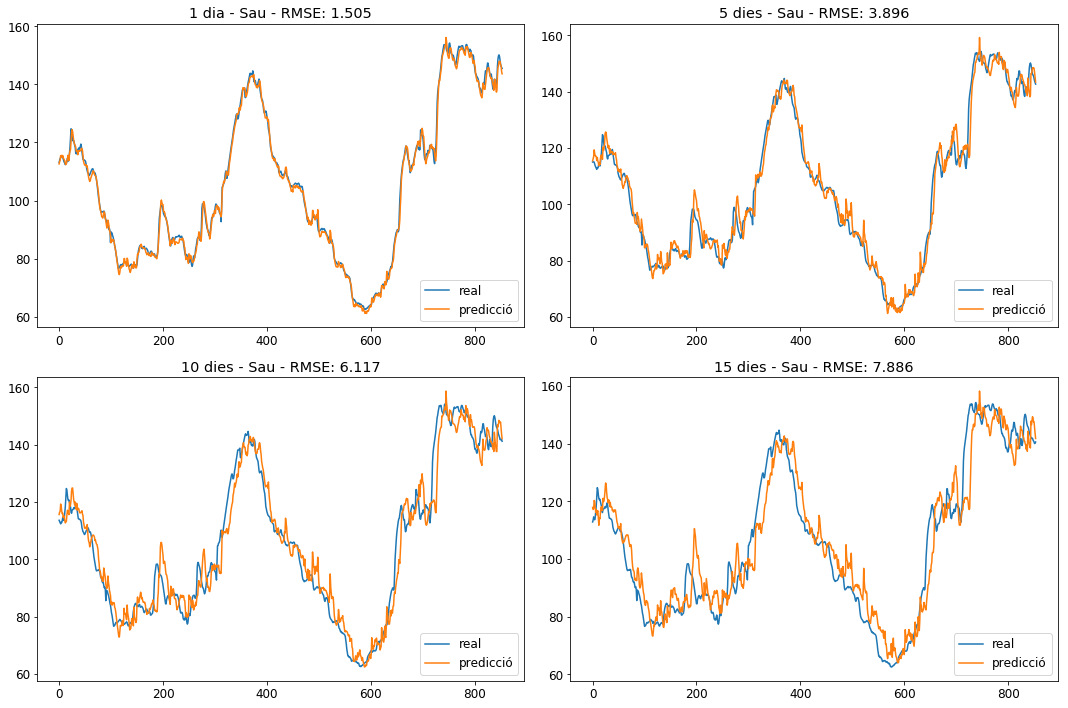

In [23]:
import matplotlib.pyplot as plt
dies = list()
    # calculem RMSE per cada dia
    
for i in range(test_YR.shape[1]):
    # calculem MSE
    dies.append((test_YR[:, i], testPredict[:, i]))

%matplotlib inline
plt.rcParams["figure.figsize"] = [15,10]
title1 = '1 dia - Sau - RMSE: '+str(round(RMSE_days[0],3))
title5 = '5 dies - Sau - RMSE: '+str(round(RMSE_days[4],3))
title10 = '10 dies - Sau - RMSE: '+str(round(RMSE_days[9],3))
title15 = '15 dies - Sau - RMSE: '+str(round(RMSE_days[14],3))

plt.rcParams.update({'font.size': 12})

plt.subplots_adjust(hspace=0.5)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# plot time signal:
axes[0, 0].set_title(title1)
axes[0, 0].plot(dies[0][0], label='real')
axes[0, 0].plot(dies[0][1], label='predicció')
axes[0, 0].legend(loc=4)

axes[0, 1].set_title(title5)
axes[0, 1].plot(dies[4][0], label='real')
axes[0, 1].plot(dies[4][1], label='predicció')
axes[0, 1].legend(loc=4)

axes[1, 0].set_title(title10)
axes[1, 0].plot(dies[9][0], label='real')
axes[1, 0].plot(dies[9][1], label='predicció')
axes[1, 0].legend(loc=4)

axes[1, 1].set_title(title15)
axes[1, 1].plot(dies[14][0], label='real')
axes[1, 1].plot(dies[14][1], label='predicció')
axes[1, 1].legend(loc=4)


fig.tight_layout()
plt.show()

In [24]:
from tabulate import tabulate
headers=[]
for i in range(len(RMSE_days)):
    headers.append('dia '+str(i+1))

headers.append('Total')
v = RMSE_days
ultim = v.append(RMSE_TOT)
table1 = tabulate([RMSE_days[0:5]], headers[0:5], tablefmt="fancy_grid")
table2 = tabulate([RMSE_days[5:10]], headers[5:10], tablefmt="fancy_grid")
table3 = tabulate([RMSE_days[10:16]], headers[10:16], tablefmt="fancy_grid")
#output
print(table1)
print(table2)
print(table3)

╒═════════╤═════════╤═════════╤═════════╤═════════╕
│   dia 1 │   dia 2 │   dia 3 │   dia 4 │   dia 5 │
╞═════════╪═════════╪═════════╪═════════╪═════════╡
│  1.5048 │ 2.18466 │ 2.78668 │ 3.33225 │  3.8961 │
╘═════════╧═════════╧═════════╧═════════╧═════════╛
╒═════════╤═════════╤═════════╤═════════╤══════════╕
│   dia 6 │   dia 7 │   dia 8 │   dia 9 │   dia 10 │
╞═════════╪═════════╪═════════╪═════════╪══════════╡
│ 4.42821 │ 4.78258 │ 5.27182 │ 5.69823 │  6.11665 │
╘═════════╧═════════╧═════════╧═════════╧══════════╛
╒══════════╤══════════╤══════════╤══════════╤══════════╤═════════╕
│   dia 11 │   dia 12 │   dia 13 │   dia 14 │   dia 15 │   Total │
╞══════════╪══════════╪══════════╪══════════╪══════════╪═════════╡
│  6.52517 │   6.8369 │  7.12594 │  7.56775 │  7.88557 │ 5.42093 │
╘══════════╧══════════╧══════════╧══════════╧══════════╧═════════╛


In [12]:
import numpy as np
from keras import optimizers
n_steps_out = 15
propTrainTest = 0.8
n_steps_in = 7
train_X, test_X, train_Y, test_Y = train_test(n_steps_in, n_steps_out, propTrainTest, datasetN)
n_input = train_X.shape[1] * train_X.shape[2]
train_X = train_X.reshape((train_X.shape[0], n_input))
test_X = test_X.reshape((test_X.shape[0], n_input))
adam = optimizers.Adam(lr=0.000790)
model = Sequential()
model.add(Dense(48, activation='sigmoid', input_dim=n_input))
model.add(Dense(n_steps_out))
model.compile(loss='mse', optimizer=adam)
# fit model
modelfit = model.fit(train_X, train_Y, epochs=337, batch_size=126, verbose=0)
# Predict on new data
yhat = model.predict(test_X)        # invertim prediccions per tenir-les en l'escala original
# invertim prediccions per tenir-les en l'escala original
yhat2 = yhat.reshape((yhat.shape[0]*yhat.shape[1], 1))
test_Y2 = test_Y.reshape((test_Y.shape[0]*test_Y.shape[1], 1))
#dataset2 = hstack((yhat2,yhat2,yhat2,yhat2,yhat2,yhat2,yhat2,test_Y2))
dataset2 = hstack((yhat2,yhat2,yhat2,yhat2,yhat2,test_Y2))
inv_yhat = scaler.inverse_transform(dataset2)
testPredict = inv_yhat[:,0].reshape(test_Y.shape[0], test_Y.shape[1])
#test_YR = inv_yhat[:,7].reshape(test_Y.shape[0], test_Y.shape[1])
test_YR = inv_yhat[:,5].reshape(test_Y.shape[0], test_Y.shape[1])

RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
print(RMSE_TOT)

5.443451009074863


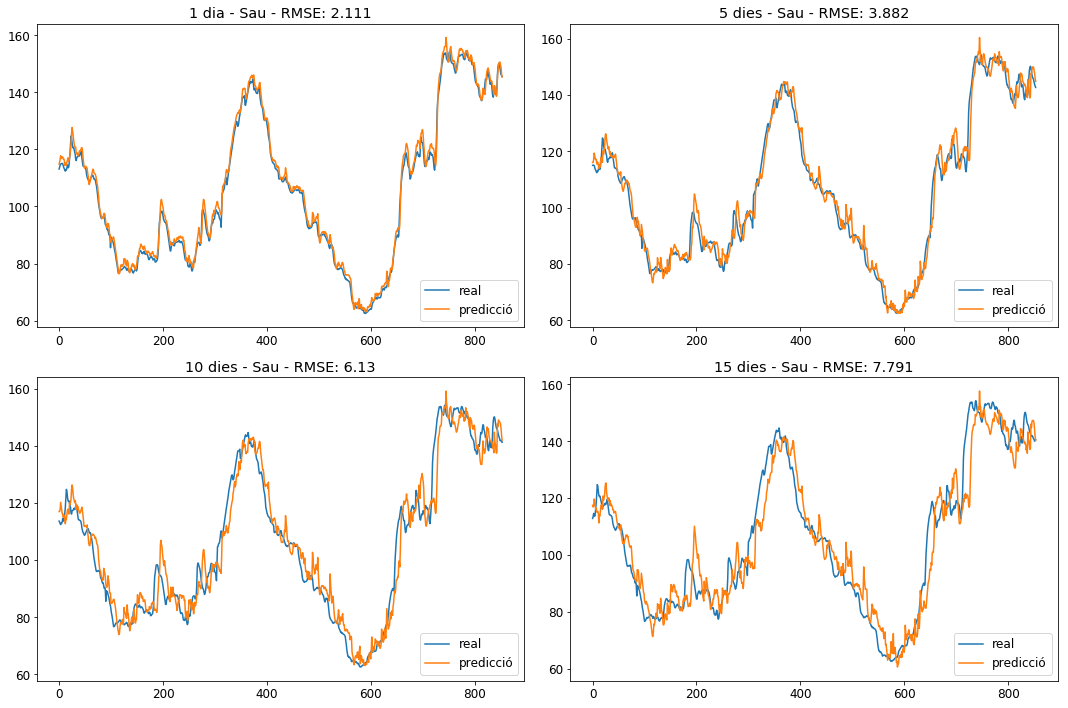

In [21]:
import matplotlib.pyplot as plt
dies = list()
    # calculem RMSE per cada dia
    
for i in range(test_YR.shape[1]):
    # calculem MSE
    dies.append((test_YR[:, i], testPredict[:, i]))

%matplotlib inline
plt.rcParams["figure.figsize"] = [15,10]
title1 = '1 dia - Sau - RMSE: '+str(round(RMSE_days[0],3))
title5 = '5 dies - Sau - RMSE: '+str(round(RMSE_days[4],3))
title10 = '10 dies - Sau - RMSE: '+str(round(RMSE_days[9],3))
title15 = '15 dies - Sau - RMSE: '+str(round(RMSE_days[14],3))

plt.rcParams.update({'font.size': 12})

plt.subplots_adjust(hspace=0.5)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# plot time signal:
axes[0, 0].set_title(title1)
axes[0, 0].plot(dies[0][0], label='real')
axes[0, 0].plot(dies[0][1], label='predicció')
axes[0, 0].legend(loc=4)

axes[0, 1].set_title(title5)
axes[0, 1].plot(dies[4][0], label='real')
axes[0, 1].plot(dies[4][1], label='predicció')
axes[0, 1].legend(loc=4)

axes[1, 0].set_title(title10)
axes[1, 0].plot(dies[9][0], label='real')
axes[1, 0].plot(dies[9][1], label='predicció')
axes[1, 0].legend(loc=4)

axes[1, 1].set_title(title15)
axes[1, 1].plot(dies[14][0], label='real')
axes[1, 1].plot(dies[14][1], label='predicció')
axes[1, 1].legend(loc=4)


fig.tight_layout()
plt.show()

In [20]:
resultatsDEF=[]
for i, j in zip (test_YR, testPredict):
    resultatsDEF.append((i,j))
    
resultatsDEF = pd.DataFrame(resultatsDEF)
resultatsDEF.columns=['ytest','predict']
resultatsDEF.to_csv('mlp-multi-sau-test-predict.csv', sep=',', encoding='utf-8')

In [22]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
def evaluate_forecasts_rquad(actual, predicted):
    scores = list()
    # calculem RMSE per cada dia
    for i in range(actual.shape[1]):
        # calculem MSE
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        r_quad = r2_score(actual[:, i], predicted[:, i])
        mae = mean_absolute_error(actual[:, i], predicted[:, i])
        # calculem RMSE
        rmse = sqrt(mse)
        # store
        scores.append((rmse,r_quad,mae,mse))
    # calcul global de RMSE
    s = 0
    r = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

In [23]:
RMSE_TOT, RMSE_days = evaluate_forecasts_rquad(test_YR,testPredict)
global_y = test_YR.reshape((test_YR.shape[0]*test_YR.shape[1], 1))
global_pred = testPredict.reshape((testPredict.shape[0]*testPredict.shape[1], 1))
r_quad = r2_score(global_y, global_pred)
rmse = sqrt(mean_squared_error(global_y, global_pred))
mse = mean_squared_error(global_y, global_pred)
mae = mean_absolute_error(global_y, global_pred)

res_globals=[rmse, r_quad, mae, mse]

resultsDF =  pd.DataFrame(RMSE_days)
resultsDF = resultsDF.T
resultsDF['Global'] = res_globals
resultsDF.columns=['dia 1','dia 2','dia 3','dia 4','dia 5','dia 6','dia 7','dia 8','dia 9','dia 10','dia 11','dia 12','dia 13','dia 14','dia 15', 'global']
resultsDF.rename(index={0:'RMSE',1:'R2',2:'MAE', 3:'MSE'}, inplace=True)
resultsDF = resultsDF.round(4)
display(resultsDF)

,dia 1,dia 2,dia 3,dia 4,dia 5,dia 6,dia 7,dia 8,dia 9,dia 10,dia 11,dia 12,dia 13,dia 14,dia 15,global
RMSE,2.1106,2.6147,3.0091,3.4669,3.8818,4.3483,4.7856,5.3104,5.7616,6.1304,6.4505,6.8070,7.1532,7.5125,7.7908,5.4435
R2,0.9932,0.9897,0.9863,0.9819,0.9774,0.9717,0.9657,0.9579,0.9506,0.9441,0.9383,0.9314,0.9244,0.9168,0.9107,0.9558
MAE,1.7408,2.0508,2.2327,2.5589,2.8551,3.1556,3.5255,3.9955,4.3597,4.6220,4.8265,5.1869,5.4940,5.6816,5.9308,3.8811
MSE,4.4548,6.8367,9.0545,12.0197,15.0683,18.9076,22.9021,28.2002,33.1956,37.5815,41.6093,46.3349,51.1676,56.4376,60.6970,29.6312


In [24]:
RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
v = RMSE_days
ultim = v.append(RMSE_TOT)

dades_diesDF=pd.DataFrame(v)
dades_diesDF=dades_diesDF.round(3)
dades_diesDF=dades_diesDF.T
dades_diesDF.columns=['dia 1','dia 2','dia 3','dia 4','dia 5','dia 6','dia 7','dia 8','dia 9','dia 10','dia 11','dia 12','dia 13','dia 14','dia 15', 'global']
dades_diesDF.rename(index={0:'RMSE'}, inplace=True)

display(dades_diesDF)

,dia 1,dia 2,dia 3,dia 4,dia 5,dia 6,dia 7,dia 8,dia 9,dia 10,dia 11,dia 12,dia 13,dia 14,dia 15,global
RMSE,2.111,2.615,3.009,3.467,3.882,4.348,4.786,5.31,5.762,6.13,6.451,6.807,7.153,7.512,7.791,5.443


In [25]:
resultsDF.to_csv('mlp-multi-sau.csv', sep=',', encoding='utf-8')